# Exploring L2A Reflectance

**Summary**  

In this notebook we will open a Level 2A (L2A) Reflectance product file (netcdf) from Earth Surface Mineral Dust Source Investigation (EMIT). We will inspect the structure and plot the spectra of individual pixels and spatial coverage of a single band. Next, we will orthorectify the imagery using the included geometry lookup table (GLT). Finally, we will take advantage of the `holoviews streams` module to build an interactive plot.

**Background**

The EMIT instrument is an imaging spectrometer that measures light in visible and infrared wavelengths. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. More details about EMIT and its associated products can be found in the **README.md** and on the [EMIT website](https://earth.jpl.nasa.gov/emit/).

The L2A Reflectance Product contains estimated surface reflectance. Surface reflectance is the fraction of incoming solar radiation reflected Earth's surface. Materials reflect proportions of radiation differently based upon their chemical composition.  This means that reflectance information can be used to determine the composition of a target. In this guide you will learn how to plot a band from the L2A reflectance spatially and look at the spectral curve associated with individual pixels.

**Requirements**
 - Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder

**Learning Objectives**  
- How to open an EMIT `.nc` file as an `xarray.Dataset`
- Apply the Geometry Lookup Table (GLT) to orthorectify the image.
- How to plot the spectra of pixels
- How to plot specific bands as images
- How to make an interactive plot to visualize spectra

**Tutorial Outline**  

1.1 Setup  
1.2 Opening The Data  
1.3 Plotting Data - Non-Orthorectified  
1.4 Orthorectification  
1.5 Plotting Data - Orthorectified  
1.6 Saving Orthorectified Data  
1.7 Interactive Plots  

![Interactive Plot](../../img/interactive_plot.png)

---

## 1.1 Setup

Import the required Python libraries.

In [36]:
!pip install earthaccess
!pip install rasterio
!pip install hvplot
!pip install datashader
!pip install netcdf4
!pip install jupyter_bokeh

import earthaccess
import os
from osgeo import gdal
import numpy as np
import math
import rasterio as rio
import xarray as xr
import holoviews as hv
import hvplot.xarray
import netCDF4 as nc
import matplotlib.pyplot as plt

  Could not find a version that satisfies the requirement earthaccess (from versions: )
No matching distribution found for earthaccess
panel 0.13.1 has requirement bokeh<2.5.0,>=2.4.0, but you'll have bokeh 2.3.3 which is incompatible.
panel 0.13.1 has requirement bokeh<2.5.0,>=2.4.0, but you'll have bokeh 2.3.3 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/4e/f7/ca60537cd166c0b770bdcc85f9bcc0ef68adb68152eaa561eefc3ebe5ebd/datashader-0.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/19/66/6b2c49c7c68da48d17059882fdb9ad9ac9e5ac3f22b00874d7996e3c44a8/llvmlite-0.36.0.tar.gz
  Running setup.py bdist_wheel for llvmlite ... error
  Failed building wheel for llvmlite
  Running setup.py clean for llvmlite
Failed to build llvmlite
panel 0.13.1 has requirement bokeh<2.5.0,>=2.4.0, but you'll have bokeh 2.3.3 which is incompatible.
  Running setup.py install for llvmlite ... error
Command "/usr/local/bin/python -u -c "import setupto

Login to your NASA Earthdata account and create a `.netrc` file using the `login` function from the `earthaccess` library. If you do not have an Earthdata Account, you can create one [here](https://urs.earthdata.nasa.gov/home).

In [37]:
earthaccess.login(persist=True)

We are already authenticated with NASA EDL


For this notebook we will download the files necessary using `earthaccess`. You can also access the data in place or stream it, but this can slow due to the file sizes. Provide a URL for an EMIT L2A Reflectance granule.

In [38]:
url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230119T114235_2301907_004/EMIT_L2A_RFL_001_20230119T114235_2301907_004.nc'

Get an HTTPS Session using your earthdata login, set a local path to save the file, and download the granule asset - This may take a while, the reflectance file is approximately 1.8 GB.

In [43]:
from google.colab import drive
import warnings

drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [47]:
# Get Https Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
granule_asset_id = url.split('/')[-1]
# Define Local Filepath
fp = f'/content/drive/MyDrive/emit_data/{granule_asset_id}'
#   fp = f'../../data/{granule_asset_id}'
# Download the Granule Asset if it doesn't exist
if not os.path.isfile(fp):
    fs.download(url, fp)

---

## 1.2 Opening EMIT Data  

EMIT L2A Reflectance Data are distributed in a non-orthocorrected spatially raw NetCDF4 (.nc) format consisting of the data and its associated metadata. Inside the L2A Reflectance `.nc` file there are 3 groups. Groups can be thought of as containers to organize the data.

1. The root group that can be considered the main dataset contains the reflectance data described by the downtrack, crosstrack, and bands dimensions.  
2. The `sensor_band_parameters`  group containing the wavelength center and the full-width half maximum (FWHM) of each band.  
3. The `location` group contains latitude and longitude values at the center of each pixel described by the crosstrack and downtrack dimensions, as well as a geometry lookup table (GLT) described by the ortho_x and ortho_y dimensions. The GLT is an orthorectified image (EPSG:4326) consisting of 2 layers containing downtrack and crosstrack indices. These index positions allow us to quickly project the raw data onto this geographic grid.

To access the `.nc` file we will use the `netCDF4` and `xarray` libraries. The `netCDF4` library will be used to explore thee data structure, then we will use `xarray` to work with the data. `xarray` is a python package for working with labelled multi-dimensional arrays. It provides a data model where data, dimensions, and attributes together in an easily interpretable way.

In [48]:
ds_nc = nc.Dataset(fp)
ds_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    ncei_template_version: NCEI_NetCDF_Swath_Template_v2.0
    summary: The Earth Surface Mineral Dust Source Investigation (EMIT) is an Earth Ventures-Instrument (EVI-4) Mission that maps the surface mineralogy of arid dust source regions via imaging spectroscopy in the visible and short-wave infrared (VSWIR). Installed on the International Space Station (ISS), the EMIT instrument is a Dyson imaging spectrometer that uses contiguous spectroscopic measurements from 410 to 2450 nm to resolve absoprtion features of iron oxides, clays, sulfates, carbonates, and other dust-forming minerals. During its one-year mission, EMIT will observe the sunlit Earth's dust source regions that occur within +/-52° latitude and produce maps of the source regions that can be used to improve forecasts of the role of mineral dust in the radiative forcing (warming or cooling) of the atmosphere.\n\nThis file contains L2A esti

From this output, we can see the `reflectance` variable, and the  `sensor_band_parameters` and `location` groups. We can also see the dimensions, their sizes, and file metadata.

Now that we have a better understanding of the structure of the file, read the EMIT data as an `xarray.Dataset` and preview it.

In [49]:
ds = xr.open_dataset(fp)
ds

<xarray.Dataset>
Dimensions:      (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    reflectance  (downtrack, crosstrack, bands) float32 ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             -34.666333239147725
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.78304980e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

This `xarray` dataset only contains the `reflectance` variable and attributes metadata, not the data from the other groups in the file. This is because `xarray` only supports reading non-hierarchical (flat) datasets, meaning that when loading a NetCDF into an `xarray.Dataset`, only the root group is added. The other groups will have to be read into `xarray` separately. We can list them using the `netCDF4` library to get the group names, then use that to add them to new `xarray` datasets.

In [50]:
ds_nc.groups.keys()

dict_keys(['sensor_band_parameters', 'location'])

Now that we know the other group names, read the `sensor_band_parameters` and `location` groups into their own `xarray` datasets.

In [51]:
wvl = xr.open_dataset(fp,group='sensor_band_parameters')
wvl

<xarray.Dataset>
Dimensions:           (bands: 285)
Dimensions without coordinates: bands
Data variables:
    wavelengths       (bands) float32 ...
    fwhm              (bands) float32 ...
    good_wavelengths  (bands) float32 ...

In [52]:
loc = xr.open_dataset(fp,group='location')
loc

<xarray.Dataset>
Dimensions:  (downtrack: 1280, crosstrack: 1242, ortho_y: 1904, ortho_x: 2362)
Dimensions without coordinates: downtrack, crosstrack, ortho_y, ortho_x
Data variables:
    lon      (downtrack, crosstrack) float64 ...
    lat      (downtrack, crosstrack) float64 ...
    elev     (downtrack, crosstrack) float64 ...
    glt_x    (ortho_y, ortho_x) float64 ...
    glt_y    (ortho_y, ortho_x) float64 ...

We could merge all 3 datasets, but since `sensor_band_parameters` and `location` describe various aspects of the `reflectance` variable we can simply add them as coordinates, along with a downtrack and crosstrack dimension to describe the reflectance data array. This will allow us to utilize some additional features of `xarray`.

In [53]:
# Create coordinates and an index for the downtrack and crosstrack dimensions, then unpack the variables from the wvl and loc datasets and set them as coordinates for ds
ds = ds.assign_coords({'downtrack':(['downtrack'], ds.downtrack.data),'crosstrack':(['crosstrack'],ds.crosstrack.data), **wvl.variables, **loc.variables})
ds

<xarray.Dataset>
Dimensions:           (downtrack: 1280, crosstrack: 1242, bands: 285,
                       ortho_y: 1904, ortho_x: 2362)
Coordinates:
  * downtrack         (downtrack) int64 0 1 2 3 4 5 ... 1275 1276 1277 1278 1279
  * crosstrack        (crosstrack) int64 0 1 2 3 4 ... 1237 1238 1239 1240 1241
    wavelengths       (bands) float32 ...
    fwhm              (bands) float32 ...
    good_wavelengths  (bands) float32 ...
    lon               (downtrack, crosstrack) float64 ...
    lat               (downtrack, crosstrack) float64 ...
    elev              (downtrack, crosstrack) float64 ...
    glt_x             (ortho_y, ortho_x) float64 ...
    glt_y             (ortho_y, ortho_x) float64 ...
Dimensions without coordinates: bands, ortho_y, ortho_x
Data variables:
    reflectance       (downtrack, crosstrack, bands) float32 ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             -34.666333239147725
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.78304980e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

Another step we can take is to swap the 'bands' dimension with wavelengths. Doing this will allow us to index based on the wavelength of the band, and remove 'bands' as a dimension. We can do this since bands is just a 3rd dimension that will is defined based on the 'sensor_band_parameters' group (i.e. 'wavelengths' for reflectance, or 'mask_bands' for mask data).

In [54]:
ds = ds.swap_dims({'bands':'wavelengths'})
ds

<xarray.Dataset>
Dimensions:           (downtrack: 1280, crosstrack: 1242, wavelengths: 285,
                       ortho_y: 1904, ortho_x: 2362)
Coordinates:
  * downtrack         (downtrack) int64 0 1 2 3 4 5 ... 1275 1276 1277 1278 1279
  * crosstrack        (crosstrack) int64 0 1 2 3 4 ... 1237 1238 1239 1240 1241
  * wavelengths       (wavelengths) float32 381.0 388.4 ... 2.486e+03 2.493e+03
    fwhm              (wavelengths) float32 ...
    good_wavelengths  (wavelengths) float32 ...
    lon               (downtrack, crosstrack) float64 ...
    lat               (downtrack, crosstrack) float64 ...
    elev              (downtrack, crosstrack) float64 ...
    glt_x             (ortho_y, ortho_x) float64 ...
    glt_y             (ortho_y, ortho_x) float64 ...
Dimensions without coordinates: ortho_y, ortho_x
Data variables:
    reflectance       (downtrack, crosstrack, wavelengths) float32 ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             -34.666333239147725
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.78304980e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

In [55]:
# prompt: wavelengthsの値を全て表示してください

#ds['wavelengths'].values


Now we have an `xarray.Dataset` containing all of the information from EMIT netCDF file. Since these datasets are large, we can go ahead and delete objects we won't be using to conserve memory.

In [56]:
#ds['reflectance'].min()

In [57]:
del wvl
del loc

---

## 1.3 Visualizing Spectra - Non-Orthorectified

Pick a random downtrack and crosstrack location. Here we chose 660, 370 (downtrack,crosstrack). Next use the `sel()` function from `xarray` and the `hvplot.line()` functions to first select the spatial position and then plot a line showing the reflectance at that location.

In [58]:
example = ds['reflectance'].sel(downtrack=660,crosstrack=370)
example.hvplot.line(y='reflectance',x='wavelengths', color='black')

:Curve   [wavelengths]   (reflectance)

We can see some flat regions in the spectral curve around 1320-1440 nm and 1770-1970 nm. These are where water absoption features in these regions were removed. Typically this data is noisy due to the moisture present in the atmosphere; therefore, these spectral regions offer little information about targets and can be excluded from calculations.

We can set reflectance values where the `good_wavelenghts` is 0 (these will have a reflectance of -0.1) to `np.nan` do mask them out and improve visualization.

In [59]:
ds['reflectance'].data[:,:,ds['good_wavelengths'].data==0] = np.nan

Plot the filtered reflectance values using the same downtrack and crosstrack position as above.

In [60]:
ds['reflectance'].sel(downtrack=660,crosstrack=370).hvplot.line(y='reflectance',x='wavelengths', color='black')

:Curve   [wavelengths]   (reflectance)

Without these data we can better interpret the spectral curve and `hvplot` will do a better job automatically scaling our axes.

We can also plot the data spatially. Since we changed our dimension and index to `wavelengths` we can use the `sel()` function to spectrally subset to the wavelength nearest to 850nm in the NIR, then plot the data spatially using `hvplot.image()` to view the reflectance at 850nm of each pixel across the acquired region.

In [61]:
#ds['reflectance'].data[:,:,ds['good_wavelengths'].data!=0].max()

In [62]:
refl850 = ds.sel(wavelengths=850, method='nearest')
refl850

<xarray.Dataset>
Dimensions:           (downtrack: 1280, crosstrack: 1242, ortho_y: 1904,
                       ortho_x: 2362)
Coordinates:
  * downtrack         (downtrack) int64 0 1 2 3 4 5 ... 1275 1276 1277 1278 1279
  * crosstrack        (crosstrack) int64 0 1 2 3 4 ... 1237 1238 1239 1240 1241
    wavelengths       float32 850.1
    fwhm              float32 ...
    good_wavelengths  float32 1.0
    lon               (downtrack, crosstrack) float64 ...
    lat               (downtrack, crosstrack) float64 ...
    elev              (downtrack, crosstrack) float64 ...
    glt_x             (ortho_y, ortho_x) float64 ...
    glt_y             (ortho_y, ortho_x) float64 ...
Dimensions without coordinates: ortho_y, ortho_x
Data variables:
    reflectance       (downtrack, crosstrack) float32 0.03642 0.0343 ... 0.2067
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             -34.666333239147725
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.78304980e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

In [63]:
#!pip install ipywidgets

In [64]:
#from google.colab import output
#output.enable_custom_widget_manager()

In [65]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [66]:
#from IPython.display import display
#display(refl850.hvplot.image(cmap='viridis', aspect = 'equal', rasterize=True))

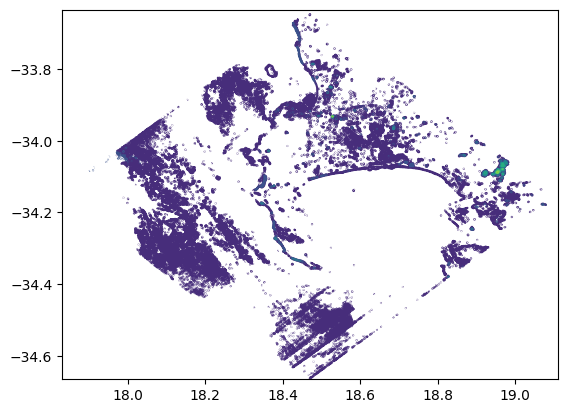

In [67]:
refl380 = ds.sel(wavelengths=380, method='nearest')
plt.contour(refl380.lon, refl380.lat, refl380.reflectance)
plt.show()

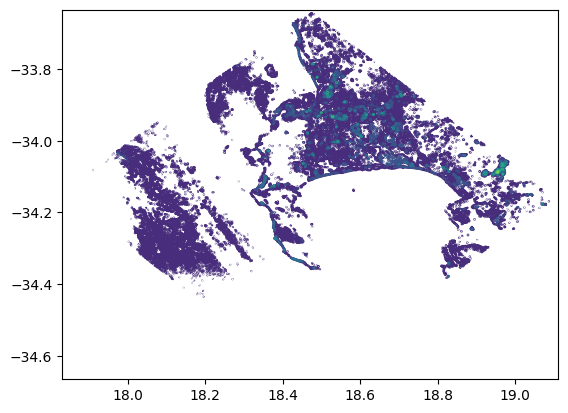

In [68]:
refl450 = ds.sel(wavelengths=450, method='nearest')
plt.contour(refl450.lon, refl450.lat, refl450.reflectance)
plt.show()

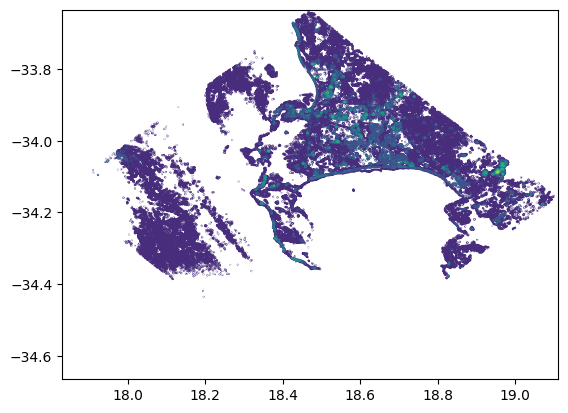

In [69]:
refl520 = ds.sel(wavelengths=520, method='nearest')
plt.contour(refl520.lon, refl520.lat, refl520.reflectance)
plt.show()

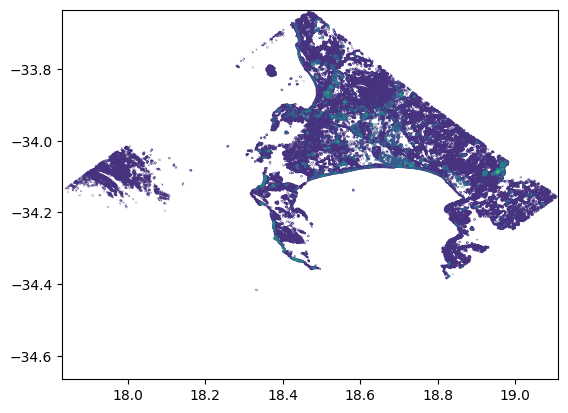

In [70]:
refl700 = ds.sel(wavelengths=700, method='nearest')
plt.contour(refl700.lon, refl700.lat, refl700.reflectance)
plt.show()

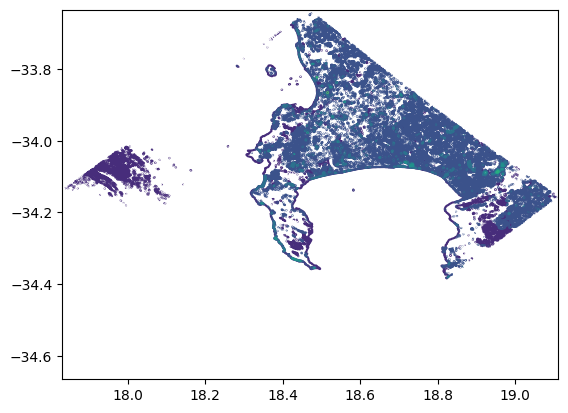

In [71]:
plt.contour(refl850.lon, refl850.lat, refl850.reflectance)
plt.show()

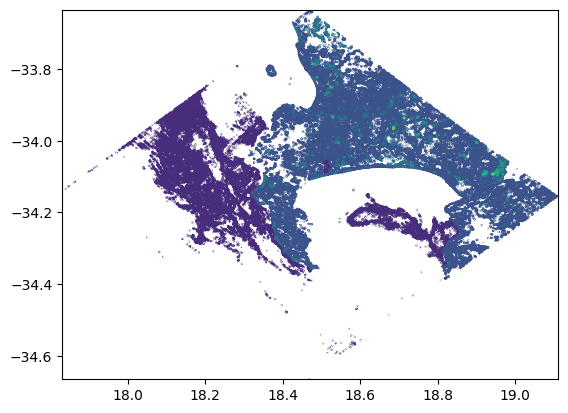

In [72]:
refl1450 = ds.sel(wavelengths=1450, method='nearest')
plt.contour(refl1450.lon, refl1450.lat, refl1450.reflectance)
plt.show()

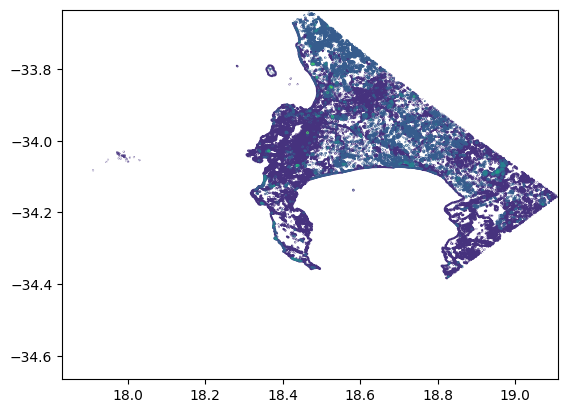

In [73]:
refl1600 = ds.sel(wavelengths=1600, method='nearest')
plt.contour(refl1600.lon, refl1600.lat, refl1600.reflectance)
plt.show()

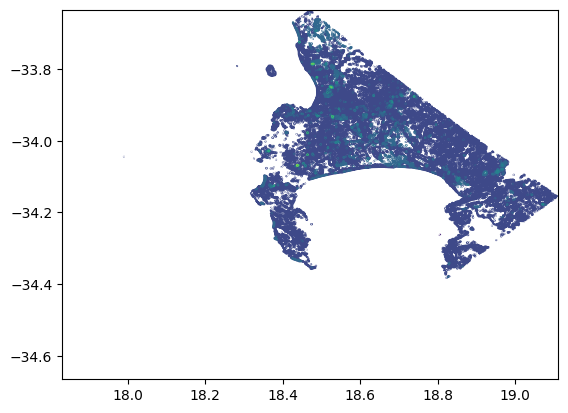

In [74]:
refl2200 = ds.sel(wavelengths=2200, method='nearest')
plt.contour(refl2200.lon, refl2200.lat, refl2200.reflectance)
plt.show()

# NDVI：正規化植生指数

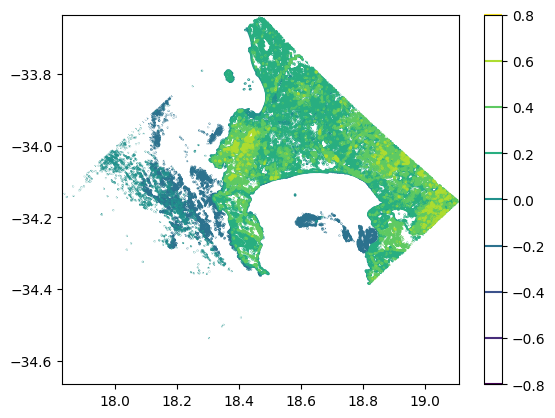

In [75]:
ndvi = (refl850.reflectance - refl700.reflectance) / (refl850.reflectance + refl700.reflectance)
plt.contour(refl850.lon, refl850.lat, ndvi)
plt.colorbar()
plt.show()



```
# これはコードとして書式設定されます
```

# NDWI:地表面水分量

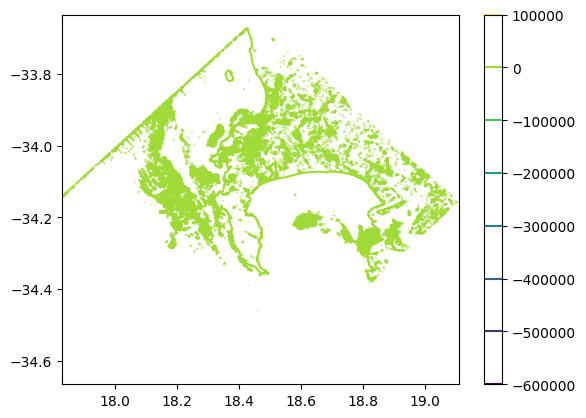

In [76]:
ndwi_p = (refl700.reflectance - refl1450.reflectance) / (refl700.reflectance + refl1450.reflectance)
plt.contour(refl700.lon, refl700.lat, ndwi_p)
plt.colorbar()
plt.show()

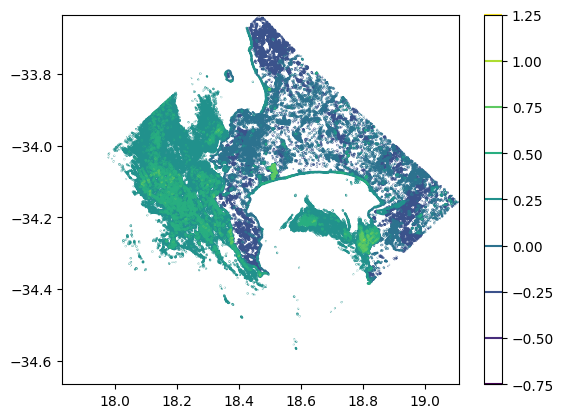

In [77]:
ndwi_p = (refl700.reflectance - refl2200.reflectance) / (refl700.reflectance + refl2200.reflectance)
plt.contour(refl700.lon, refl700.lat, ndwi_p)
plt.colorbar()
plt.show()



```
# これはコードとして書式設定されます
```

# NDWI:植生水分量

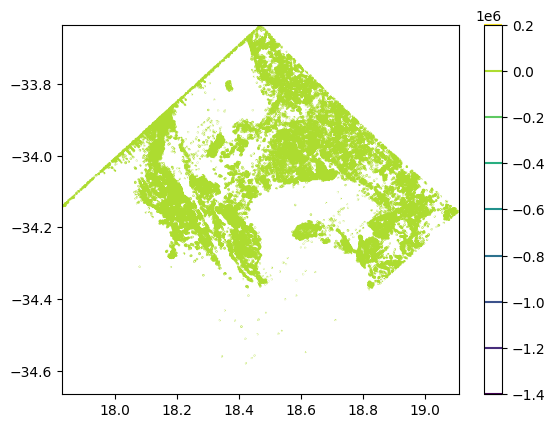

In [78]:
ndwi_l = (refl850.reflectance - refl1450.reflectance) / (refl850.reflectance + refl1450.reflectance)
plt.contour(refl850.lon, refl850.lat, ndwi_l)
plt.colorbar()
plt.show()

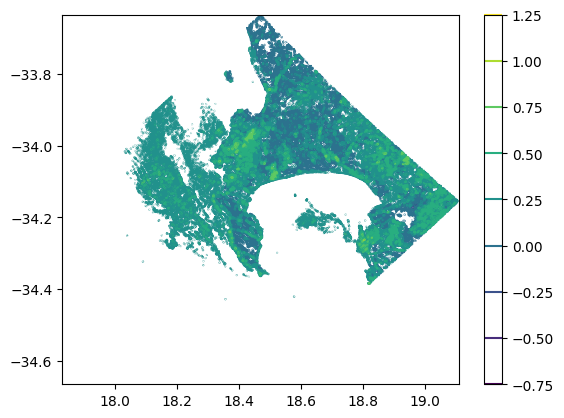

In [79]:
ndwi_l = (refl850.reflectance - refl2200.reflectance) / (refl850.reflectance + refl2200.reflectance)
plt.contour(refl850.lon, refl850.lat, ndwi_l)
plt.colorbar()
plt.show()

# GSI（Grain Size Index）粒径指標
GSI =（RedーBlue）/（Red＋Blue＋Green）

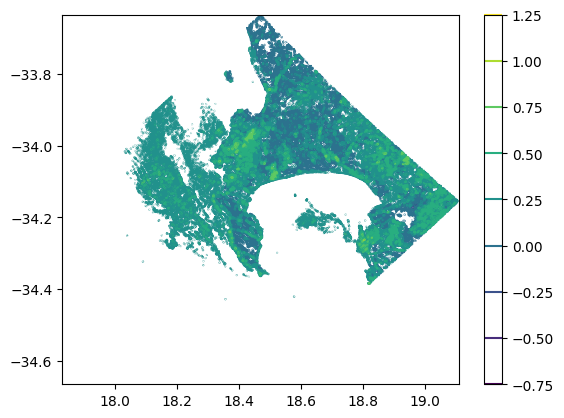

In [80]:
gsi = (refl700.reflectance - refl450.reflectance) / (refl700.reflectance + refl450.reflectance + refl520.reflectance)
plt.contour(refl850.lon, refl850.lat, ndwi_l)
plt.colorbar()
plt.show()

# NDBI　(Normalized Difference Built-up Index)正規化都市化指数
 NDBI = (SWIR2ーNIR) / (SWIR2＋NIR)

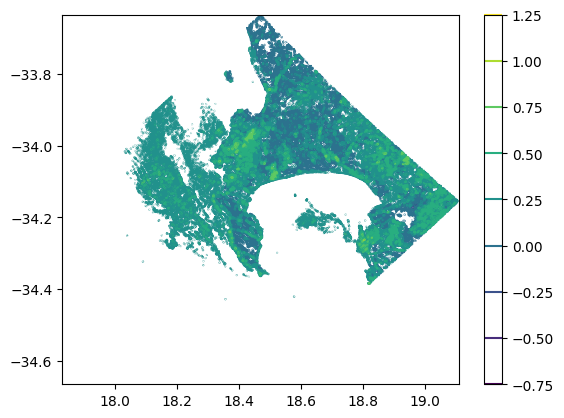

In [81]:
ndbi = (refl1600.reflectance - refl850.reflectance) / (refl1600.reflectance + refl850.reflectance)
plt.contour(refl850.lon, refl850.lat, ndwi_l)
plt.colorbar()
plt.show()

---

## 1.4 Orthorectification

The 'real' orthorectifation process has already been done for EMIT data. Here we are using the crosstrack and downtrack indices contained in the GLT to place our spatially raw reflectance data a into geographic grid with the `ortho_x` and `ortho_y` dimensions. As previously mentioned a Geometry Lookup Table (GLT) is included in the `location` group of the netCDF4 file. Applying the GLT will orthorectify the data and give us Latitude and Longitude positional information.

Before using the GLT to orthorectify the data, examine the `location` group from the dataset by reading it into `xarray`.


In [82]:
loc = xr.open_dataset(fp,group='location')
loc

<xarray.Dataset>
Dimensions:  (downtrack: 1280, crosstrack: 1242, ortho_y: 1904, ortho_x: 2362)
Dimensions without coordinates: downtrack, crosstrack, ortho_y, ortho_x
Data variables:
    lon      (downtrack, crosstrack) float64 ...
    lat      (downtrack, crosstrack) float64 ...
    elev     (downtrack, crosstrack) float64 ...
    glt_x    (ortho_y, ortho_x) float64 ...
    glt_y    (ortho_y, ortho_x) float64 ...

We can see that each downtrack and crosstrack position has a latitude, longitude, and elevation, and the ortho_x and ortho_y data make up glt_x and glt_y arrays with a different shape. These arrays contain crosstrack and downtrack index values to quickly reproject the data. We will use these indexes to build an array of 2009x2353x285 (lat,lon,bands), filling it with the data from the reflectance dataset.

Go ahead and remove this dataset. We will use a function in the provided `emit_tools` module to orthorectify the data and place it into an `xarray.Dataset`.

In [83]:
del loc
del example

Import the `emit_tools` module and call use the help function to see how it can be used.

> Note: This function currently works with L1B Radiance and L2A Reflectance Data.


In [84]:
!git clone https://github.com/nasa/EMIT-Data-Resources.git

fatal: destination path 'EMIT-Data-Resources' already exists and is not an empty directory.


In [85]:
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2023-10-08 06:39:27--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.245.55, 104.16.246.55, 2606:4700::6810:f537, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.245.55|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2023-10-08 06:39:27--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.3’

     0K .......... .......... .......... .......... ..........  0% 8.82M 6s
    50K .......... .......... .......... .......... ..........  

In [86]:
!conda activate base
!conda env create -f EMIT-Data-Resources/setup/emit_tutorials_macos.yml


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
If your shell is Bash or a Bourne variant, enable conda for the current user with

    $ echo ". /usr/local/etc/profile.d/conda.sh" >> ~/.bashrc

or, for all users, enable conda with

    $ sudo ln -s /usr/local/etc/profile.d/conda.sh /etc/profile.d/conda.sh

The options above will permanently enable the 'conda' command, but they do NOT
put conda's base (root) environment on PATH.  To do so, run

    $ conda activate

in your terminal, or to put the base environment on PATH permanently, run

    $ echo "conda activate" >> ~/.bashrc

Previous to conda 4.4, the recommended way to activate conda was to modify PATH in
your ~/.bashrc file.  You should manually remove the line that looks like

    export PATH="/usr/local/bin:$PATH"

^^^ The above line should NO LONGER be in your ~/.bashrc file! ^^^


Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / -

In [87]:
!pip install spectral

panel 0.13.1 has requirement bokeh<2.5.0,>=2.4.0, but you'll have bokeh 2.3.3 which is incompatible.


In [88]:
!pip list

Package             Version     
------------------- ------------
affine              2.3.1       
asn1crypto          0.24.0      
attrs               22.2.0      
bleach              4.1.0       
bokeh               2.3.3       
certifi             2018.4.16   
cffi                1.11.5      
cftime              1.6.0       
chardet             3.0.4       
click               8.0.4       
click-plugins       1.1.1       
cligj               0.7.2       
cloudpickle         2.2.1       
colorcet            3.0.1       
conda               4.5.4       
contextvars         2.4         
cryptography        2.2.2       
dask                2021.3.0    
datashape           0.5.2       
distributed         2021.3.0    
fsspec              2022.1.0    
HeapDict            1.0.1       
holoviews           1.14.9      
hvplot              0.8.4       
idna                2.6         
immutables          0.19        
importlib-metadata  4.8.3       
importlib-resources 5.4.0       
Jinja2    

In [89]:
import sys
sys.path.append('EMIT-Data-Resources/python/modules/')
sys.path.append('/usr/local/lib/python3.6/site-packages')
# /content/EMIT-Data-Resources/python/modules/emit_tools.py

from emit_tools import emit_xarray
help(emit_xarray)

Help on function emit_xarray in module emit_tools:

emit_xarray(filepath, ortho=False, qmask=None, unpacked_bmask=None)
    This function utilizes other functions in this module to streamline opening an EMIT dataset as an xarray.Dataset.
    
    Parameters:
    filepath: a filepath to an EMIT netCDF file
    ortho: True or False, whether to orthorectify the dataset or leave in crosstrack/downtrack coordinates.
    qmask: a numpy array output from the quality_mask function used to mask pixels based on quality flags selected in that function. Any non-orthorectified array with the proper crosstrack and downtrack dimensions can also be used.
    unpacked_bmask: a numpy array from  the band_mask function that can be used to mask band-specific pixels that have been interpolated.
                    
    Returns:
    out_xr: an xarray.Dataset constructed based on the parameters provided.



We can see that the `emit_xarray` function will automatically apply the GLT to orthorectify the data unless `ortho  = False`. The function will also apply masks if desired during construction of the output `xarray.Dataset`. EMIT L2A Masks files provides a quality mask and a band_mask indicating if values were interpolated. For more about masking, see the [How_to_use_EMIT_Quality_data.ipynb](../how-tos/How_to_use_EMIT_Quality_data.ipynb).

Use the `emit_xarray` function to read in and orthorectify the L2A reflectance data.

>**For a detailed walkthrough of the orthorectification process using the GLT see section 2 of the How_to_Orthorectify.ipynb in the how-tos folder.**

In [90]:
!pip install rioxarray

    100% |████████████████████████████████| 1.1MB 12.1MB/s 
  Installing build dependencies ... done
    100% |████████████████████████████████| 174kB 31.1MB/s 
  Installing build dependencies ... done
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-install-vc_k9p7o/pyproj/


In [ ]:
import rioxarray

In [ ]:
ds_geo = emit_xarray(fp, ortho=True)
ds_geo

---

## 1.5 Plotting Data - Orthorectified

Now that the data has been orthorectified, plot the georeferenced dataset using the same single wavelength (850nm) as above. We can use the `aspect = 'equal'` option to preserve the square pixel dimensions. The `rasterize = True` will help save memory and reduces the size of this notebook. For higher quality outputs, this can be omitted.

In [ ]:
ds_geo.sel(wavelengths=850, method='nearest').hvplot.image(cmap='viridis', aspect = 'equal', rasterize=True) +\
     ds.sel(wavelengths=850, method='nearest').hvplot.image(cmap='viridis', aspect = 'equal', rasterize=True)

We an also plot the data against an imagery tile using the `geo=True` and `tiles=` parameters instead of . Any tile source available in `geoviews` should work here. This will change the  axis names, but that can be fixed by adding them manually in the options, like below.

In [ ]:
ds_geo.sel(wavelengths=850, method='nearest').hvplot.image(cmap='viridis', frame_width=500, geo=True, tiles='EsriImagery').opts(
    xlabel=f'{ds_geo.longitude.long_name} ({ds_geo.longitude.units})', ylabel=f'{ds_geo.latitude.long_name} ({ds_geo.latitude.units})')

We can see that the orthorectification step placed the data on a geogrpahic grid that matches pretty well with ESRI tiles. Now that we have a better idea of what the target area looks like, we can also plot the spectra using the georeferenced data. First, filter out the water absorption bands like we did earlier. By limiting the third dimension of the array to `good_wavelengths`.

In [ ]:
ds_geo['reflectance'].data[:,:,ds_geo['good_wavelengths'].data==0] = np.nan

Now, plot the spectra at the Lat/Lon coordinates provided below.

In [ ]:
point = ds_geo.sel(longitude=-61.833,latitude=-39.710,method='nearest')
point.hvplot.line(y='reflectance',x='wavelengths', color='black', frame_width=400).opts(
    title = f'Latitude = {point.latitude.values.round(3)}, Longitude = {point.longitude.values.round(3)}')

---

## 1.6 Writing an Orthorectified Output

At this point, the `ds_geo` orthorectified EMIT data can also be written as a flattened netCDF4 output that can be read using the `xarray.open_dataset` function, if desired.

In [ ]:
#ds_geo.to_netcdf('../data/geo_ds_out.nc')

# Example for Opening
# ds = xr.open_dataset('../data/geo_ds_out.nc')

---

## 1.7 Interactive Spatial and Spectral Plots

Combining the Spatial and Spectral information into a single visualization can be a powerful tool for exploring and inspecting imaging spectroscopy data. Using the `streams` module from `Holoviews` we can link a spatial map to a plot of spectra.

We could plot a single band image as we previously have, but using a multiband image, like an RGB may help infer what targets we're examining. Build an RGB image following the steps below.

Select bands to represent red (650 nm), green (560 nm), and blue (470 nm) by finding the nearest to a wavelength chosen to represent that color.

> Note that if subsetting by bands like this example, it is more memory efficient to subset before orthorectifying. Instead of using `ortho=True` in the `emit_xarray` function, select bands first, then apply the orthorectification using the `ortho_xr` function from `emit_tools.py` (requires a separate import).

In [ ]:
rgb = ds_geo.sel(wavelengths=[650, 560, 470], method='nearest')
rgb

Next, write a function to scale the values using a gamma correction. Without applying this scaling the majority of the image would be very dark, with the reflectance data being skewed by the few pixels with very high reflectance.
> Note: This has no impact on analysis or data, just visualizing the RGB map.

In [ ]:
# Function to adjust gamma across all bands - adjust brightness
def gamma_adjust(rgb_ds, bright=0.2, white_background=False):
    array = rgb_ds.reflectance.data
    gamma = math.log(bright)/math.log(np.nanmean(array)) # Create exponent for gamma scaling - can be adjusted by changing 0.2
    scaled = np.power(array,gamma).clip(0,1) # Apply scaling and clip to 0-1 range
    if white_background == True:
        scaled = np.nan_to_num(scaled, nan = 1) # Assign NA's to 1 so they appear white in plots
    rgb_ds.reflectance.data = scaled
    return rgb_ds

In [ ]:
rgb = gamma_adjust(rgb, white_background=True)

Now that we have an RGB dataset, use it to build our spatial plot.

In [ ]:
map = rgb.hvplot.rgb(x='longitude', y='latitude', bands='wavelengths', aspect = 'equal', frame_width=400)

To visualize the spectral and spatial data side-by-side, we use the `pointerXY` and `Tap` functions from the `streams` module from the `holoviews` library.

Define objects resulting from the stream of the pointer x and y position on our spatial plot, `map`, then define objects resulting from a clicked x and y position on the same `map`.

Next, build a function to plot the spectra based on these two sets of x and y coordinates on the map. This will allow us to return spectra from a position we clicked on the image, and spectra where the mouse is currently hovering, allowing comparison of pixel reflectance values.

In [ ]:
# Stream of X and Y positional data
posxy = hv.streams.PointerXY(source=map, x=-61.833, y=-39.710)
clickxy = hv.streams.Tap(source=map, x=-61.833, y=-39.710)

# Function to build a new spectral plot based on mouse hover positional information retrieved from the RGB image using our full reflectance dataset
def point_spectra(x,y):
    return ds_geo.sel(longitude=x,latitude=y,method='nearest').hvplot.line(y='reflectance',x='wavelengths',
                                                                           color='#1b9e77', frame_width=400)
# Function to build spectral plot of clicked location to show on hover stream plot
def click_spectra(x,y):
    clicked = ds_geo.sel(longitude=x,latitude=y,method='nearest')
    return clicked.hvplot.line(y='reflectance',x='wavelengths', color='black', frame_width=400).opts(
        title = f'Latitude = {clicked.latitude.values.round(3)}, Longitude = {clicked.longitude.values.round(3)}')
# Define the Dynamic Maps
point_dmap = hv.DynamicMap(point_spectra, streams=[posxy])
click_dmap = hv.DynamicMap(click_spectra, streams=[clickxy])

# Plot the Map and Dynamic Map side by side
(map + click_dmap*point_dmap)

---

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 06-29-2022  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  